# Guess Core and use other methods to interpolate

In [1]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate, guess
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import datetime

#! Only if there are no cudo CPUs in the system!
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"


2025-06-24 16:43:40.013772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 16:43:40.080621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750776220.123275    9059 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750776220.141220    9059 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750776220.206113    9059 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 1b) Try on other dataset!

In [2]:
import sys, os
from glob import glob
sys.path.append("..")
from BlockMatrix import BlockMatrix
from utils import  plot_mat_comp, flatten_triang_batch, flatten_triang, get_overlap, load_mol, unflatten_triang, density_from_fock, perform_calculation
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap


In [3]:
train_test_seed = 42
source_path = '../../datasets/QM9/xyz_c7h10o2_sorted/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
n_elec = 19
len(all_file_paths)

all_file_paths = all_file_paths[:1024]


In [4]:
def load_cached(file_paths, cache_path, basis, guess="minao", method="dft", functional="b3lypg", backend="pyscf"):
    error_list = []
    error_files = []
    focks = []
    overlaps = []
    used_files = []
    reference_densities = []
    for file in file_paths:
        mol_name = os.path.basename(file).strip()
        # print(mol_name)
        try: 
            ret = density_fock_overlap(filepath = file,
                                filename = mol_name,
                                method = method,
                                basis = None,
                                functional = functional,
                                guess = guess,
                                backend = backend,
                                cache = cache_path)
            print(f"Using: file={file} - mol_name={mol_name} - basis={None} - guess={guess} - method={method} - functional={functional}")
        except Exception as e: 
            error_list.append(e)
            error_files.append(mol_name)
            print(f"File {mol_name} error - skipping")
            continue
        if any([r == None for r in ret]): 
            print(f"File {mol_name} bad - skipping")
            continue
        focks.append(ret[1].numpy)
        used_files.append(file)
        reference_densities.append(ret[0].numpy)
        overlaps.append(ret[2].numpy)
    print(f"Got data for: {len(focks)} - bad / no ret: {len(file_paths) - len(focks) - len(error_list)} - errors: {len(error_list)}")
    print(error_files[:5])
    return focks, reference_densities, overlaps, used_files


In [5]:
ret = load_cached(all_file_paths, "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf", basis="6-31g_2df_p_custom_nwchem.gbs")

Using: file=../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_064590.xyz - mol_name=dsgdb9nsd_064590.xyz - basis=None - guess=minao - method=dft - functional=b3lypg
Using: file=../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_107832.xyz - mol_name=dsgdb9nsd_107832.xyz - basis=None - guess=minao - method=dft - functional=b3lypg
Using: file=../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_107555.xyz - mol_name=dsgdb9nsd_107555.xyz - basis=None - guess=minao - method=dft - functional=b3lypg
Using: file=../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_079400.xyz - mol_name=dsgdb9nsd_079400.xyz - basis=None - guess=minao - method=dft - functional=b3lypg
Using: file=../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_058746.xyz - mol_name=dsgdb9nsd_058746.xyz - basis=None - guess=minao - method=dft - functional=b3lypg
Using: file=../../datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_094408.xyz - mol_name=dsgdb9nsd_094408.xyz - basis=None - guess=minao - method=dft - functional=b3lypg
Using: file=../../data

In [6]:
from sklearn.model_selection import train_test_split
train_test_seed = 42
all_data = [(fock, ref_density, overlap, file) for fock, ref_density, overlap, file in zip(*ret)]
print(len(all_data))
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=train_test_seed) 

1024


In [7]:
mat_dim = train_data[0][0].shape
mat_dim

(284, 284)

In [8]:
train_overlap_X = np.array([flatten_triang(data[2]) for data in train_data])
# train_fock_Y = np.array([data[0] for data in train_data])
train_fock_diag = np.array([np.diag(data[0]) for data in train_data])

test_overlap_X = np.array([flatten_triang(data[2]) for data in test_data])
# test_fock_Y = np.array([data[0] for data in test_data])
test_fock_diag = np.array([np.diag(data[0]) for data in test_data])
train_overlap_X.shape, test_overlap_X.shape

((819, 40470), (205, 40470))

In [9]:
import pickle as pk
with open("data/train_overlap_X.pk", "wb") as f:
    pk.dump(train_overlap_X, f)
with open("data/train_fock_diag.pk", "wb") as f:
    pk.dump(train_fock_diag, f)
with open("data/test_overlap_X.pk", "wb") as f:
    pk.dump(test_overlap_X, f)
with open("data/test_fock_diag.pk", "wb") as f:
    pk.dump(test_fock_diag, f)

In [10]:
# load data
import pickle as pk
with open("data/train_overlap_X.pk", "rb") as f:
    train_overlap_X = pk.load(f)
with open("data/train_fock_diag.pk", "rb") as f:
    train_fock_diag = pk.load(f)
with open("data/test_overlap_X.pk", "rb") as f:
    test_overlap_X = pk.load(f)
with open("data/test_fock_diag.pk", "rb") as f:
    test_fock_diag = pk.load(f)

In [11]:
custom_631g_basis = "../../scripts/6-31g_2df_p_custom_nwchem.gbs"
example_mol_filepath = os.path.basename(train_data[0][3]).strip()
example_mol = load_mol(train_data[0][3], custom_631g_basis, Backend.PY)
example_ovlp = unflatten_triang(train_overlap_X[0], mat_dim[0])
example_overlap = BlockMatrix(example_mol, example_ovlp)
example_overlap.plot_blocks_by_type("all", labels="atoms", figsize=(10, 10), imshow_args={"cmap": "RdBu"})

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

let's try our luck! - no rescaling for now 

In [12]:
import tensorflow as tf
in_dim = train_overlap_X.shape[1]
out_dim = train_fock_diag.shape[1]
in_dim, out_dim

(40470, 284)

In [13]:
tf.random.set_seed(42)
flattened_dim = train_overlap_X.shape[1]
diag_dim = train_fock_diag.shape[1]
inputs_orig = tf.keras.Input(shape=(flattened_dim,))
x = inputs_orig
for neurons in [1024,1024,512]:
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # if neurons == 512:
    #     x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(diag_dim)(x)

basic_model = tf.keras.Model(inputs=inputs_orig, outputs=outputs)
basic_model.compile(optimizer='adam', loss="mae", metrics=["mse"])

2025-06-24 16:43:54.917902: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
basic_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40470)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    41,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 284)            │       145,692 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,172,636 (164.69 MB)

 Trainable params: 43,167,516 (164.67 MB)

 Non-trainable params: 5,120 (20.00 KB)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step - loss: 2.3012 - mse: 11.2434 - val_loss: 2.2855 - val_mse: 11.6834
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - loss: 2.0641 - mse: 10.0548 - val_loss: 2.3432 - val_mse: 12.8408
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - loss: 1.7628 - mse: 8.3948 - val_loss: 1.6292 - val_mse: 8.2880
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - loss: 1.1601 - mse: 5.3828 - val_loss: 0.8988 - val_mse: 3.6483
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - loss: 0.7204 - mse: 3.0403 - val_loss: 0.5294 - val_mse: 2.2460
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - loss: 0.5648 - mse: 1.9798 - val_loss: 0.4453 - val_mse: 1.6570
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - loss: 0.4651 - mse: 1.3234 - val_loss: 0.2588 - val_mse: 0.6208
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - loss: 0.3725 - mse: 0.7987 - val_loss: 0.1985 - val_mse: 0.3061
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 401

Text(0.5, 1.0, 'Model loss')

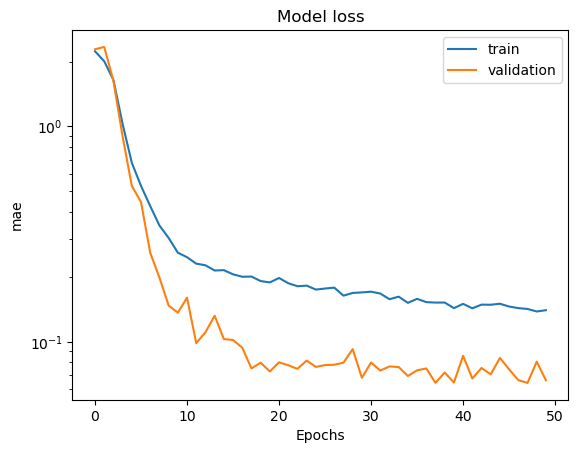

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("models/basic_model_6_31G.keras", save_best_only=True)
basic_hist = basic_model.fit(train_overlap_X, train_fock_diag,
                            validation_data=(test_overlap_X, test_fock_diag),
                            epochs=50,
                            batch_size=32,
                            callbacks=[tensorboard_callback, checkpoint_callback],
                            verbose=1)
# Plot the training and validation loss
plt.plot(basic_hist.history['loss'], label='train')
plt.plot(basic_hist.history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

In [16]:
os.makedirs("models", exist_ok=True)
if os.path.exists("models/basic_model_6_31G.keras") and input("Overwrite existing model? (y/n)") == "y":
    os.remove("models/basic_model_6_31G.keras")
    
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")
else:
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")

Model saved


In [17]:
# load model
loaded_model = tf.keras.models.load_model("models/basic_model_6_31G.keras")
basic_model = loaded_model

In [18]:
def reconstruct_Fock(diag, ovlp, K = 1.75): 
    """Take diagonal and reconstruct the Fock matrix using GWH
    """
    mat_dim = diag.shape[0]
    out = np.zeros((mat_dim, mat_dim))
    for i in range(mat_dim):
        for j in range(mat_dim):
            if i == j:
                out[i, j] = diag[i]
            else:
                out[i, j] = K * ovlp[i, j] * (diag[i] + diag[j]) / 2
    return out

In [19]:
# predict: 
test_pred_fock_diag = basic_model.predict(test_overlap_X)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


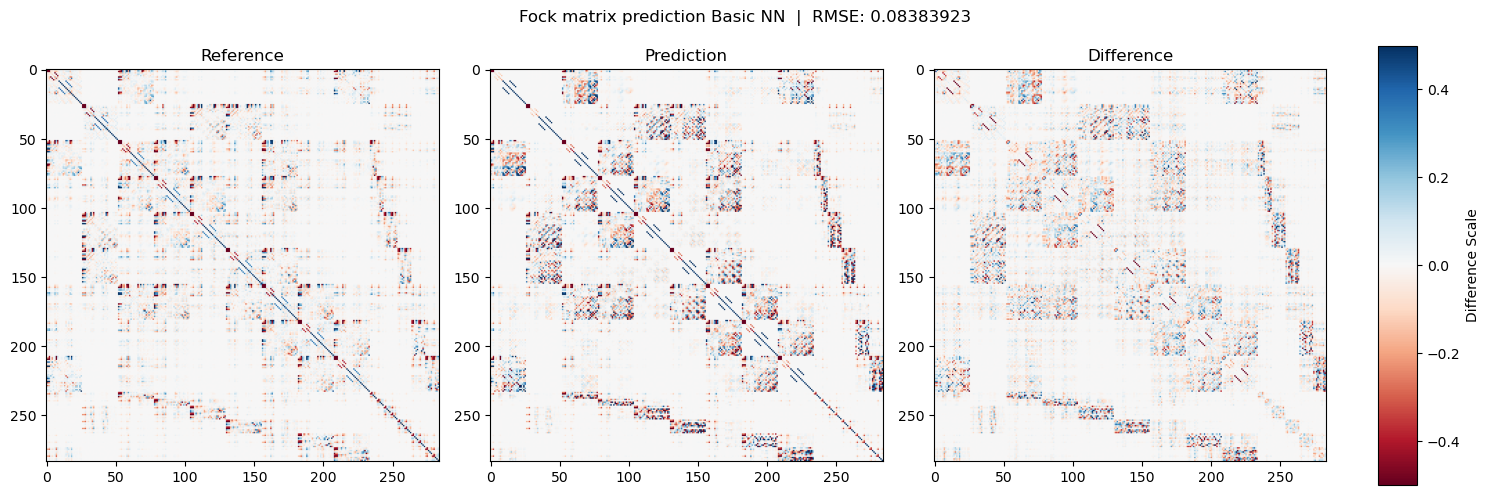

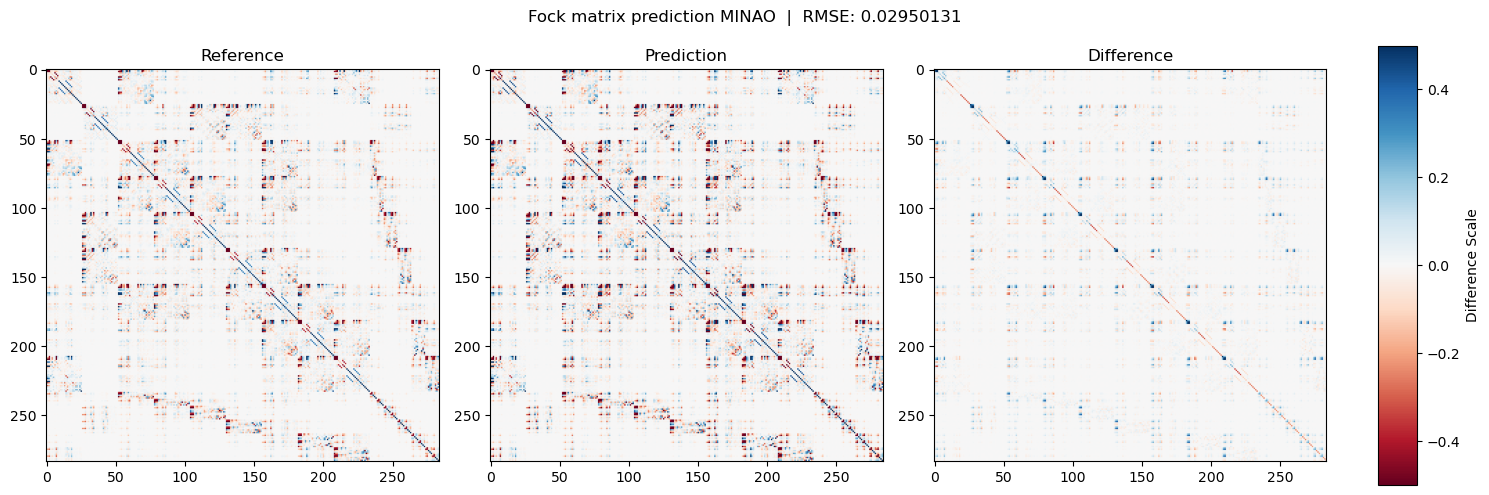

In [20]:
# example comparison: 
rand_test_sample = np.random.randint(0, len(test_pred_fock_diag))
pred_fock_example = reconstruct_Fock(test_pred_fock_diag[rand_test_sample], unflatten_triang(test_overlap_X[rand_test_sample], mat_dim[0]))
ground_truth_fock_example = test_data[rand_test_sample][0]
pred_density_example = density_from_fock(pred_fock_example, unflatten_triang(test_overlap_X[rand_test_sample], mat_dim[0]), mat_dim[0])
ground_truth_density_example = test_data[rand_test_sample][1]
# compare with hückel and minao
test_mol = load(test_data[rand_test_sample][3], symmetry=False, basis = custom_631g_basis, backend=Backend.PY)
minao_guess = guess(test_mol, method="hf", basis=custom_631g_basis, scheme="minao")
hueckel_guess = guess(test_mol, method="hf", basis=custom_631g_basis, scheme="huckel")

plot_mat_comp(ground_truth_fock_example, pred_fock_example, title="Fock matrix prediction Basic NN", vmax=0.5)
plot_mat_comp(ground_truth_fock_example, minao_guess.fock().numpy, title="Fock matrix prediction MINAO", vmax=0.5)
plot_mat_comp(ground_truth_fock_example, hueckel_guess.fock().numpy, title="Fock matrix prediction Hückel", vmax=0.5)

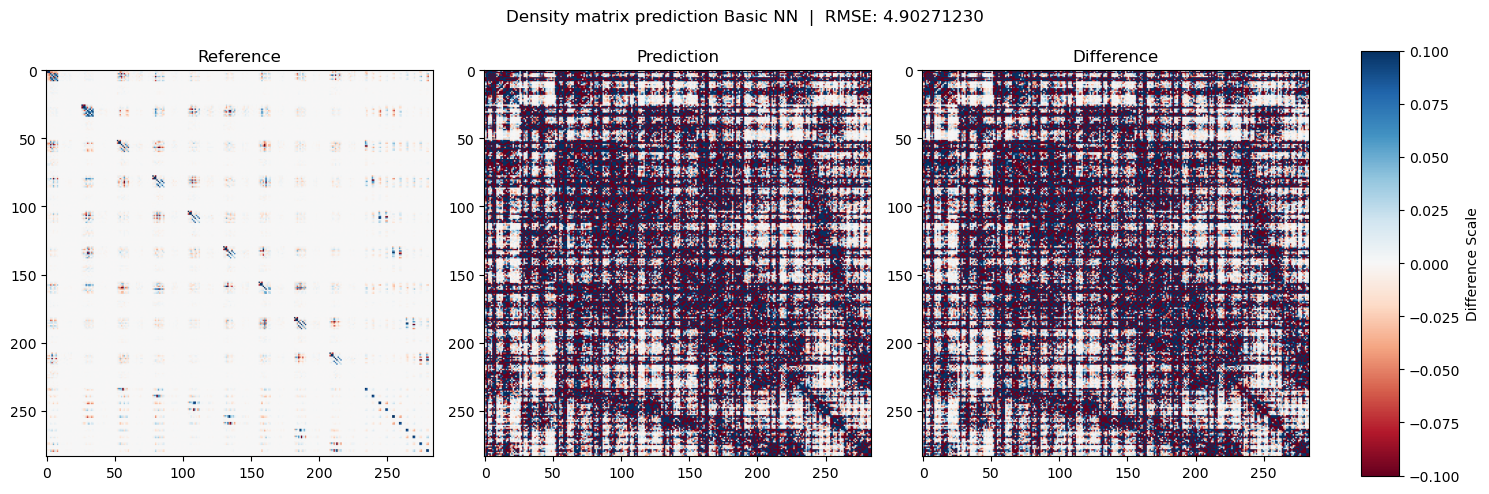

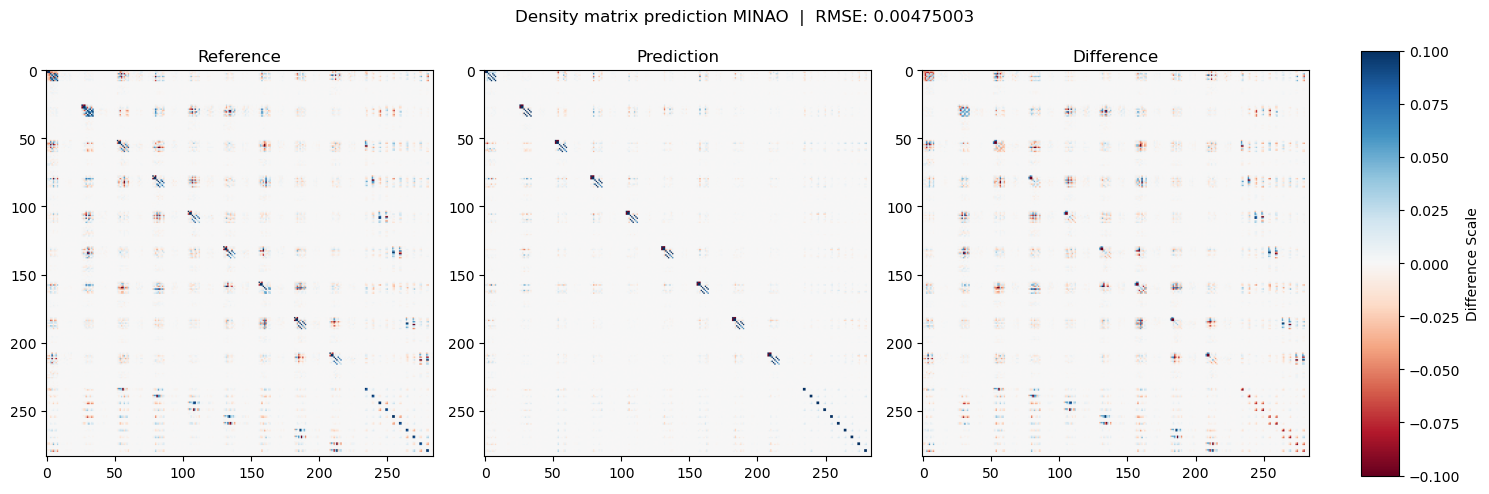

In [30]:
plot_mat_comp(ground_truth_density_example, pred_density_example, title="Density matrix prediction Basic NN", vmax=0.1)
density_from_fock_minao = density_from_fock(minao_guess.fock().numpy, unflatten_triang(test_overlap_X[rand_test_sample], mat_dim[0]), mat_dim[0])
plot_mat_comp(ground_truth_density_example, density_from_fock_minao, title="Density matrix prediction MINAO - from fock", vmax=0.1)
plot_mat_comp(ground_truth_density_example, minao_guess.density().numpy, title="Density matrix prediction MINAO", vmax=0.1)

In [22]:
# test sim
minao_res = calculate(test_mol, method="dft", functional="b3lypg", basis=custom_631g_basis, guess="minao")

Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.167644520758


In [23]:
huckel_res = calculate(test_mol, method="dft", functional="b3lypg", basis=custom_631g_basis, guess="huckel")

Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.167644520677


In [24]:
nn_res = perform_calculation(test_data[rand_test_sample][3], pred_density_example, method="dft", functional="b3lypg", basis_set=custom_631g_basis)

converged SCF energy = -423.167644521114


In [25]:
print(minao_res.native.cycles)
print(huckel_res.native.cycles)
print(nn_res["cycles"])

10
13
22
